# Neural Machine Translation with Transformers

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '20'

import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import re
import unicodedata
import matplotlib.ticker as ticker
from transformers import BertTokenizer, AutoTokenizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from parsivar import Normalizer
import tensorflow_text as tf_text 
from keras.layers import TextVectorization
import time

device = tf.config.experimental.list_physical_devices('GPU')[0]
print(device)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [2]:
en_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
fa_tokenizer = AutoTokenizer.from_pretrained('bolbolzaban/gpt2-persian')

/home/alireza/miniconda3/envs/tf15/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [3]:
def create_dataset(file_path, num_examples=None):
    en_fa = []
    cnt = 0
    fa_normalizer = Normalizer()
    with open(file_path, 'r') as file:
        for line in file.readlines():
            if num_examples is not None and cnt >= num_examples: break
            line = line.split('\t')[:2]
            en = line[0]
            fa = fa_normalizer.normalize(line[1])
            fa = re.sub('\u200c', ' ', fa)
            en_fa.append([en, fa])
            cnt += 1
            if cnt % 100 == 0:
                print(f'\rRead {cnt:>5}', end='')

    print('\nRead', cnt)
    return zip(*en_fa)


def sort_dataset(source, target):
    xy = sorted(zip(source, target), key=lambda x: (len(x[0].split(' ')), len(x[1].split(' ')))) 
    x = [x[0] for x in xy]
    y = [y[1] for y in xy]
    return x, y

## Loading the dataset

In [4]:
NUM_SAMPLES = 1_000_000
FILE_PATH = './Data/combined.txt'
src_lang, targ_lang = create_dataset(FILE_PATH, NUM_SAMPLES)

Read 994200
Read 994267


In [5]:
src_train, src_val, targ_train, targ_val = train_test_split(src_lang, targ_lang, test_size=0.2, shuffle=True)
src_train, targ_train = sort_dataset(src_train, targ_train)
src_val, targ_val = sort_dataset(src_val, targ_val)
print('Source Train examples:', len(src_train))
print('Source Validation examples:', len(src_val))

Source Train examples: 795413
Source Validation examples: 198854


In [6]:
i = -1
print('Training Example (English)')
print(src_val[i])

print('Training Example (Persian)')
print(targ_val[i])

Training Example (English)
Their eyes instantly met, and the cheeks of both were overspread with the deepest blush. He absolutely started, and for a moment seemed immovable from surprise; but shortly recovering himself, advanced towards the party, and spoke to Elizabeth, if not in terms of perfect composure, at least of perfect civility.
Training Example (Persian)
چشمان آن ها فورا به هم رسیدند و گونه های هر دو با عمیق ترین سرخ شدن بیش از حد پخش شد . او کاملا شروع کرد و برای لحظه ای از تعجب بی حرکت به نظر می رسید . اما به زودی خود را بهبود بخشید ، به سمت مهمانی پیش رفت و با الیزابت صحبت کرد ، اگر نه از نظر خونسردی کامل ، حداقل با متانت کامل .


## Create the pipeline

In [7]:
def en_vectorization(text):
    text = [x.decode('utf-8') for x in text.numpy()]
    return en_tokenizer(text, padding=True, return_tensors='tf')['input_ids']

def fa_vectorization(text):
    text = [x.decode('utf-8') for x in text.numpy()]
    return fa_tokenizer(text, padding=True, return_tensors='tf')['input_ids']

In [8]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 128
STEPS_PER_EPOCH = len(src_train) // BATCH_SIZE
BUFFER_SIZE = 1000

def preprocess(src, targ):
    src = tf.py_function(func=en_vectorization, inp=[src], Tout=tf.TensorSpec(shape=(None, None), dtype=tf.int32))
    src = tf.cast(src, tf.int32)
    targ = tf.py_function(func=fa_vectorization, inp=[targ], Tout=tf.TensorSpec(shape=(None, None), dtype=tf.int32))
    targ = tf.cast(targ, tf.int32)
    return src, targ

train_ds = tf.data.Dataset.from_tensor_slices((src_train, targ_train))
train_ds = train_ds.batch(BATCH_SIZE, num_parallel_calls=AUTOTUNE, drop_remainder=True)
train_ds = train_ds.map(preprocess,
                       num_parallel_calls=AUTOTUNE)
train_ds = train_ds.cache()
train_ds = train_ds.shuffle(STEPS_PER_EPOCH)
train_ds = train_ds.prefetch(AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((src_val, targ_val))
test_ds = test_ds.batch(BATCH_SIZE, num_parallel_calls=AUTOTUNE, drop_remainder=True)
test_ds = test_ds.map(preprocess, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.cache()
test_ds = test_ds.prefetch(AUTOTUNE)

In [9]:
print('Loading cache...')
for i, (x, y) in enumerate(train_ds): 
    print(f'\r{i:>5}', end='')
print()
for i, (x, y) in enumerate(test_ds): 
    print(f'\r{i:>5}', end='')
print()

Loading cache...
 6213
 1552


In [10]:
for example_train_source, example_train_target in test_ds.skip(10).take(10):
    print('Example Train Source:', example_train_source.shape)
    print('Example Train Target:', example_train_target.shape)
    print()

Example Train Source: (128, 9)
Example Train Target: (128, 7)

Example Train Source: (128, 8)
Example Train Target: (128, 8)

Example Train Source: (128, 8)
Example Train Target: (128, 8)

Example Train Source: (128, 9)
Example Train Target: (128, 7)

Example Train Source: (128, 8)
Example Train Target: (128, 7)

Example Train Source: (128, 8)
Example Train Target: (128, 7)

Example Train Source: (128, 8)
Example Train Target: (128, 8)

Example Train Source: (128, 8)
Example Train Target: (128, 8)

Example Train Source: (128, 9)
Example Train Target: (128, 7)

Example Train Source: (128, 9)
Example Train Target: (128, 7)



In [11]:
for i in range(BATCH_SIZE):
    print('EXAMPLE English:', en_tokenizer.decode(example_train_source[i]))
    print('EXAMPLE Farsi:', fa_tokenizer.decode(example_train_target[i]))
    print()

EXAMPLE English: [CLS] colloquist. [SEP] [PAD] [PAD] [PAD]
EXAMPLE Farsi: [CLS] عامیانه.[SEP][PAD][PAD][PAD]

EXAMPLE English: [CLS] lanate. [SEP] [PAD] [PAD] [PAD] [PAD]
EXAMPLE Farsi: [CLS] لانه.[SEP][PAD][PAD][PAD]

EXAMPLE English: [CLS] ohio. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD]
EXAMPLE Farsi: [CLS] اوهو.[SEP][PAD][PAD]

EXAMPLE English: [CLS] commutation. [SEP] [PAD] [PAD] [PAD]
EXAMPLE Farsi: [CLS] تخفیف.[SEP][PAD][PAD][PAD]

EXAMPLE English: [CLS] silicic. [SEP] [PAD] [PAD] [PAD]
EXAMPLE Farsi: [CLS] سیلیسی.[SEP][PAD][PAD]

EXAMPLE English: [CLS] furunculosis. [SEP] [PAD]
EXAMPLE Farsi: [CLS] فورونکولوز.[SEP]

EXAMPLE English: [CLS] scepter. [SEP] [PAD] [PAD] [PAD]
EXAMPLE Farsi: [CLS] عصا.[SEP][PAD][PAD][PAD]

EXAMPLE English: [CLS] nicodemus. [SEP] [PAD] [PAD] [PAD]
EXAMPLE Farsi: [CLS] نیکودموس.[SEP][PAD]

EXAMPLE English: [CLS] etiolation. [SEP] [PAD] [PAD] [PAD]
EXAMPLE Farsi: [CLS] اتیولاسیون.[SEP]

EXAMPLE English: [CLS] organdie. [SEP] [PAD] [PAD] [PAD] [PAD]
EXAMPLE Far

## Define the model

In [12]:
from keras.layers import Layer, Dropout, Dense, MultiHeadAttention, Add, LayerNormalization, Embedding, Input
from keras.models import Model
from keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy
from keras.metrics import Metric
from keras.optimizers import Adam

### Positional Embedding

In [13]:
def positional_encoding(length, depth):
    depth = depth / 2

    positions = tf.range(0, length, dtype='float32')[..., None]
    depths = tf.range(depth)[None, ...] / depth

    angle_rates = 1 / (10000 ** depths)
    angle_rads = positions * angle_rates

    pos_encoding = tf.concat([tf.math.sin(angle_rads), tf.math.cos(angle_rads)], axis=-1)
    
    return pos_encoding

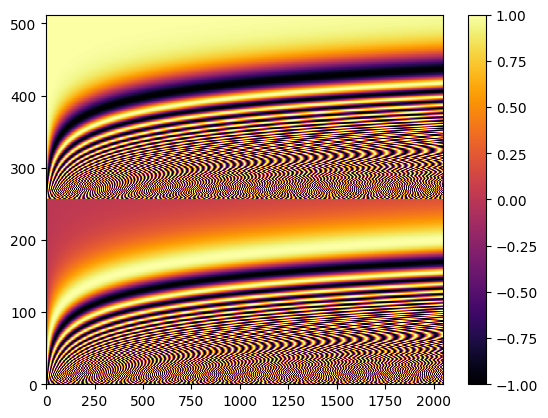

In [14]:
pos_enc = positional_encoding(2048, 512)

plt.pcolormesh(pos_enc.numpy().T, cmap='inferno');
plt.colorbar();

In [15]:
class PositionalEmbedding(Layer):
    def __init__(self, vocab_size, d_model, max_position=2048):
        super(PositionalEmbedding, self).__init__()
        self.d_model = d_model
        self.embedding = Embedding(input_dim=vocab_size, output_dim=d_model, mask_zero=True, name='embedding')
        self.pos_encoding = positional_encoding(max_position, d_model)


    def compute_mask(self, *args, **kwargs):
        return self.embedding.compute_mask(*args, **kwargs)
    
    def call(self, inputs):
        length = tf.shape(inputs)[1]
        x = self.embedding(inputs)
        # This factor sets the relative scale of the embedding and positonal_encoding.
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x = x + self.pos_encoding[tf.newaxis, :length, :]
        return x

### Base Attention

In [16]:
class BaseAttention(Layer):
    def __init__(self, **kwargs):
        super(BaseAttention, self).__init__()

        self.mha = MultiHeadAttention(**kwargs)
        self.add = Add(name='add')
        self.layernorm = LayerNormalization(name='layernorm')

### Cross Attention

In [17]:
class CrossAttention(BaseAttention):
    def __init__(self, **kwargs):
        super(CrossAttention, self).__init__(**kwargs)


    def call(self, query, context, training=False):
        # query has the shape [B, dec_seq_len, d_model]
        # context has the shape [B, enc_seq_len, d_model]
        outputs, attention_scores = self.mha(query=query, 
                           key=context, 
                           value=context, 
                           training=training,
                           return_attention_scores=True)

        # cache attention scores
        self.attention_scores = attention_scores

        outputs = self.add([query, outputs])
        outputs = self.layernorm(outputs)

        return outputs

### Self Attention

In [18]:
class SelfAttention(BaseAttention):
    def __init__(self, **kwargs):
        super(SelfAttention, self).__init__(**kwargs)


    def call(self, inputs, training=False):
        # inputs has the shape [B, enc_seq_len, d_model]
        outputs = self.mha(query=inputs,
                           key=inputs,
                           value=inputs, 
                           training=training)

        # adds residual connection
        outputs = self.add([inputs, outputs])

        outputs = self.layernorm(outputs)
        return outputs

### Masked Multi-Head attention

In [19]:
class MaskedMultiHeadAttention(BaseAttention):
    def __init__(self, **kwargs):
        super(MaskedMultiHeadAttention, self).__init__(**kwargs)


    def call(self, inputs, training=False):
        # inputs has the shape [B, dec_seq_len, d_model]
        outputs = self.mha(query=inputs, 
                           key=inputs, 
                           value=inputs, 
                           training=training, 
                           use_causal_mask=True)

        # adds residual connection
        outputs = self.add([inputs, outputs])

        outputs = self.layernorm(outputs)
        return outputs

### Feed Forward

In [20]:
class FeedForward(Layer):
    def __init__(self, d_model, dff, dropout_rate=0.1):
        super(FeedForward, self).__init__()

        self.d_model = d_model
        self.dff = dff
        self.dropout_rate = dropout_rate

        self.W1 = Dense(dff, activation='relu')
        self.W2 = Dense(d_model, activation='linear')

        if dropout_rate > 0.0:
            self.dropout = Dropout(dropout_rate, name='dropout')

        self.add = Add(name='add')
        self.layernorm = LayerNormalization(name='layernorm')


    def call(self, inputs, training=False):
        # inputs has the shape [B, Tq, d_model]
        outputs = self.W1(inputs)
        outputs = self.W2(outputs)

        if self.dropout_rate > 0.0:
            outputs = self.dropout(outputs, training=training)

        # adds residual connection
        outputs = self.add([inputs, outputs])
        outputs = self.layernorm(outputs)
        return outputs

### Encoder Layer

In [21]:
class EncoderLayer(Layer):
    def __init__(self, d_model, num_heads, dff, dropout_rate=0.1):
        super(EncoderLayer, self).__init__()

        self.d_model = d_model
        self.dff = dff
        self.num_heads = num_heads
        self.dropout_rate = dropout_rate

        self.self_attention = SelfAttention(num_heads=num_heads, 
                                            key_dim=d_model, 
                                            dropout=dropout_rate)

        self.ffn = FeedForward(d_model=d_model, 
                               dff=dff, 
                               dropout_rate=dropout_rate)


    def call(self, inputs, training=False):
        # inputs has the shape [B, enc_seq_len, d_model]
        outputs = self.self_attention(inputs, training=training)
        outputs = self.ffn(outputs, training=training)
        return outputs

### Encoder

In [22]:
class Encoder(Layer):
    def __init__(self, *, d_model, num_heads, dff, N, vocab_size, dropout_rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_heads = num_heads
        self.dff = dff
        self.N = N
        self.vocab_size = vocab_size
        self.dropout_rate = dropout_rate

        self.positional_embedding = PositionalEmbedding(vocab_size=vocab_size, 
                                                        d_model=d_model)

        self.stacks = [EncoderLayer(d_model=d_model, 
                                    num_heads=num_heads, 
                                    dff=dff, 
                                    dropout_rate=dropout_rate) for _ in range(N)]

        if dropout_rate > 0.0:
            self.dropout = Dropout(dropout_rate, name='dropout')


    def call(self, inputs, training=False):
        # inputs has the shape [B, seq_len]
        x = self.positional_embedding(inputs)
        if self.dropout_rate > 0.0:
            x = self.dropout(x, training=training)

        for n in range(self.N):
            x = self.stacks[n](x, training=training)

        return x

### Decoder Layer

In [23]:
class DecoderLayer(Layer):
    def __init__(self, d_model, dff, num_heads, dropout_rate=0.1):
        super(DecoderLayer, self).__init__()

        self.num_heads = num_heads
        self.dff = dff
        self.d_model = d_model
        self.dropout_rate = dropout_rate

        self.masked_attention = MaskedMultiHeadAttention(num_heads=num_heads, 
                                                         key_dim=d_model, 
                                                         dropout=dropout_rate)

        self.cross_attention = CrossAttention(num_heads=num_heads, 
                                              key_dim=d_model, 
                                              dropout=dropout_rate)

        self.ffn = FeedForward(d_model=d_model, 
                               dff=dff, 
                               dropout_rate=dropout_rate)


    def call(self, inputs, context, training=False):
        # inputs has the shape [B, dec_seq_len, d_model]
        # context has the shape [B, enc_seq_len, d_model]
        outputs = self.masked_attention(inputs, training=training)
        outputs = self.cross_attention(query=outputs, 
                                       context=context, 
                                       training=training)

        # cache the attention scores
        self.last_attention_scores = self.cross_attention.attention_scores

        outputs = self.ffn(outputs, training=training)
        return outputs

### Decoder

In [24]:
class Decoder(Layer):
    def __init__(self, *, d_model, num_heads, dff, N, vocab_size, dropout_rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_heads = num_heads
        self.dff = dff
        self.N = N
        self.vocab_size = vocab_size
        self.dropout_rate = dropout_rate

        if dropout_rate > 0.0:
            self.dropout = Dropout(dropout_rate, name='dropout')

        self.positional_embedding = PositionalEmbedding(vocab_size=vocab_size, 
                                                        d_model=d_model)

        self.stacks = [DecoderLayer(d_model=d_model, 
                                    num_heads=num_heads, 
                                    dff=dff, 
                                    dropout_rate=dropout_rate) for _ in range(N)]

    
    def call(self, inputs, context, training=False):
        # inputs has the shape [B, dec_seq_len]
        # context has the shape [B, enc_seq_len, d_model]
        x = self.positional_embedding(inputs)
        if self.dropout_rate > 0.0:
            x = self.dropout(x, training=training)

        for n in range(self.N):
            x = self.stacks[n](x, context=context, training=training)


        # cache attention scores for plotting
        self.last_attention_scores = self.stacks[-1].last_attention_scores

        return x

### Transformer Architecture

In [25]:
class Transformer(Model):
    def __init__(self, *, d_model, 
                 dff, 
                 num_heads, 
                 N, 
                 source_vocab_size, 
                 target_vocab_size, 
                 dropout_rate=0.1):
        
        super(Transformer, self).__init__()

        self.d_model = d_model
        self.dff = dff
        self.num_heads = num_heads
        self.N = N
        self.source_vocab_size = source_vocab_size
        self.target_vocab_size = target_vocab_size
        self.dropout_rate = dropout_rate

        self.encoder = Encoder(d_model=d_model, 
                               num_heads=num_heads, 
                               dff=dff, 
                               N=N, 
                               vocab_size=source_vocab_size, 
                               dropout_rate=dropout_rate)


        self.decoder = Decoder(d_model=d_model, 
                               num_heads=num_heads, 
                               dff=dff, 
                               N=N, 
                               vocab_size=target_vocab_size, 
                               dropout_rate=dropout_rate)

        self.classifier = Dense(units=target_vocab_size, name='classifier')


    def build(self, input_shapes):
        source_shape, target_shape = input_shapes
        source = Input(shape=source_shape)
        target = Input(shape=target_shape)
        self.call(source, target)
        self.built = True


    def call(self, source, target, training=False):
        context = self.encoder(source, training=training)
        outputs = self.decoder(target, context=context, training=training)
        logits = self.classifier(outputs, training=training)

        try:
            # Drop the keras mask, so it doesn't scale the losses/metrics.
            del logits._keras_mask
        except AttributeError:
            pass


        return logits

In [26]:
N = 6
d_model = 256
dff = 1024
num_heads = 8
dropout_rate = 0.1

VOCAB_SRC_SIZE = en_tokenizer.vocab_size
VOCAB_TARG_SIZE = fa_tokenizer.vocab_size

transformer = Transformer(d_model=d_model, 
                          num_heads=num_heads, 
                          dff=dff,
                          N=N,  
                          source_vocab_size=VOCAB_SRC_SIZE, 
                          target_vocab_size=VOCAB_TARG_SIZE,                           
                          dropout_rate=dropout_rate)

transformer.build(input_shapes=[(None, ), (None, )])
transformer.summary()

Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Encoder)           (None, None, 256)         23594496  
                                                                 
 decoder (Decoder)           (None, None, 256)         34805248  
                                                                 
 classifier (Dense)          (None, None, 25000)       6425000   
                                                                 
Total params: 64824744 (247.29 MB)
Trainable params: 64824744 (247.29 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Training

In [27]:
loss_object = SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def masked_loss_function(y_true, pred):
    mask = tf.logical_not(tf.equal(y_true, fa_tokenizer.pad_token_id))
    loss = loss_object(y_true, pred)
    mask = tf.cast(mask, loss.dtype)
    loss *= mask
    return tf.reduce_sum(loss) / tf.reduce_sum(mask)


class MaskedAccuracy(Metric):
    def __init__(self, name='masked_accuracy', **kwargs):
        super(MaskedAccuracy, self).__init__(name=name, **kwargs)

        self.total = self.add_weight(name='total', 
                                     shape=(), 
                                     dtype='float32', 
                                     initializer='zeros')
        
        self.count = self.add_weight(name='count', 
                                     shape=(), 
                                     dtype='float32', 
                                     initializer='zeros')


    def update_state(self, y_true, pred, sample_weights=None):
        # pred = [B, dec_seq_len, target_vocab_size]
        # y_true = [B, dec_seq_len]
        y_pred = tf.argmax(pred, axis=-1)
        y_pred = tf.cast(y_pred, y_true.dtype)
        mask = tf.logical_not(tf.equal(y_true, fa_tokenizer.pad_token_id))

        match = tf.equal(y_pred, y_true)
        match = tf.logical_and(match, mask)

        match = tf.cast(match, tf.float32)
        mask = tf.cast(mask, tf.float32)

        self.total.assign_add(tf.reduce_sum(match))
        self.count.assign_add(tf.reduce_sum(mask))


    def result(self):
        return self.total / self.count if self.count != 0 else 0

    def reset_states(self):
        self.total.assign(0.0)
        self.count.assign(0.0)

In [28]:
def get_scheduler(d_model, warmup_steps=4000):
    def get_learning_rate(step):
        step = tf.cast(step, tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * tf.math.pow(warmup_steps * 1.0, -1.5)

        return tf.math.rsqrt(d_model * 1.0) * tf.minimum(arg1, arg2)

    return get_learning_rate

In [29]:
EPOCHS = 30
scheduler = get_scheduler(d_model, warmup_steps=int(0.15 * STEPS_PER_EPOCH * EPOCHS))
optimizer = Adam(beta_1=0.9, beta_2=0.98, epsilon=1e-9)

train_acc = MaskedAccuracy(name='train_acc')
valid_acc = MaskedAccuracy(name='valid_acc')

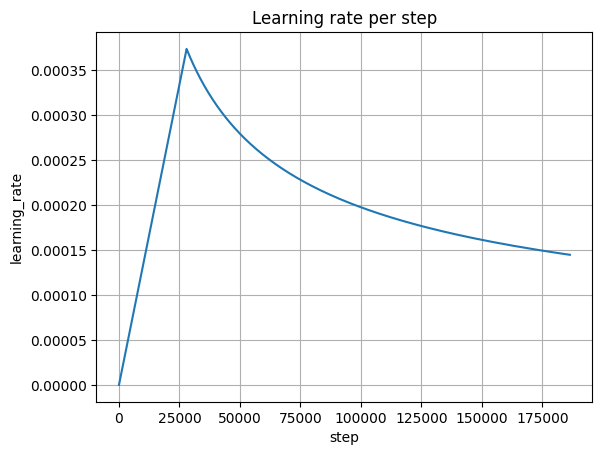

In [30]:
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(np.arange(STEPS_PER_EPOCH * EPOCHS), scheduler(np.arange(STEPS_PER_EPOCH * EPOCHS)));
ax.grid();
ax.set_title('Learning rate per step');
ax.set_xlabel('step')
ax.set_ylabel('learning_rate');

In [31]:
@tf.function(reduce_retracing=True, input_signature=[tf.TensorSpec(shape=[None, None], dtype=tf.int32), 
                                                     tf.TensorSpec(shape=[None, None], dtype=tf.int32)])
def training_step(source, target):
    loss = 0
    y_true = target[:, 1:]
    target = target[:, :-1]

    with tf.GradientTape() as tape:
        pred = transformer(source, target, training=True)
        loss = masked_loss_function(y_true, pred)
        train_acc.update_state(y_true, pred)

    variables = transformer.trainable_variables
    grads = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(grads, variables))

    return loss

In [32]:
@tf.function(reduce_retracing=True, input_signature=[tf.TensorSpec(shape=[None, None], dtype=tf.int32), 
                                                     tf.TensorSpec(shape=[None, None], dtype=tf.int32)])
def validation_step(source, target):
    loss = 0
    y_true = target[:, 1:]
    target = target[:, :-1]
    pred = transformer(source, target, training=False)
    loss = masked_loss_function(y_true, pred)
    valid_acc.update_state(y_true, pred)
    return loss

In [ ]:
train_writer = tf.summary.create_file_writer(logdir='./logs/train')
test_writer = tf.summary.create_file_writer(logdir='./logs/test')

In [ ]:
train_mean_losses = []
train_accs = []
valid_mean_losses = []
valid_accs = []
total_steps = 0

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1:>3}')
    train_acc.reset_states()
    valid_acc.reset_states()
    train_mean_loss = 0
    valid_mean_loss = 0
    start = time.time()

    for step, (source, target) in enumerate(train_ds):
        learning_rate = scheduler(total_steps)
        optimizer.learning_rate = learning_rate
        loss = training_step(source, target)
        acc = train_acc.result()
        
        train_mean_loss = train_mean_loss + (1 / (step + 1)) * (loss - train_mean_loss)
        end = time.time()
        total_steps += 1
        print(f'\r{int(end - start):>4} sec | step {step:>4}\tloss {train_mean_loss:>3.4f}\taccuracy {acc:3.2f}', end='')

        with train_writer.as_default():
            tf.summary.scalar('Loss_Per_Step', train_mean_loss, step=total_steps)
            tf.summary.scalar('Accuracy_Per_Step', acc, step=total_steps)
            
    print()
    train_mean_losses.append(train_mean_loss)
    train_accs.append(acc)

    with train_writer.as_default():
        tf.summary.scalar('Loss_Per_Epoch', train_mean_loss, step=epoch)
        tf.summary.scalar('Accuracy_Per_Epoch', acc, step=epoch)
        

    for step, (source, target) in enumerate(test_ds):
        loss = validation_step(source, target)
        acc = valid_acc.result()

        valid_mean_loss = valid_mean_loss + (1 / (step + 1)) * (loss - valid_mean_loss)
        valid_accs.append(acc)
        end = time.time()
        print(f'\r{int(end - start):>4} sec | step {step:>4}\tloss {valid_mean_loss:>3.4f}\taccuracy {acc:3.2f}', end='')
    
    valid_mean_losses.append(train_mean_loss)
    valid_accs.append(acc)

    with test_writer.as_default():
        tf.summary.scalar('Loss_Per_Epoch', valid_mean_loss, step=epoch)
        tf.summary.scalar('Accuracy_Per_Epoch', acc, step=epoch)

    transformer.save_weights(f'./{epoch + 1}.h5')
        
    print('\n')

## Translation using beam search

In [33]:
class BeamSearch:
    def __init__(self, model, en_tokenizer, fa_tokenizer, *, alpha=0.7, beam_width=5, max_length=50):
        self.model = model
        self.en_tokenizer = en_tokenizer
        self.fa_tokenizer = fa_tokenizer
        self.alpha = alpha
        self.beam_width = beam_width
        self.max_length = max_length
        self.start_token = fa_tokenizer.cls_token_id
        self.end_token = fa_tokenizer.sep_token_id
        self.vocab_size = fa_tokenizer.vocab_size
        

    def __call__(self, sentence, *, only_return_best=True):
        beam_width = self.beam_width
        
        sentence = self.en_tokenizer.encode(sentence, add_special_tokens=True)
        sentence = tf.cast(sentence, tf.int32)
        sentence = tf.expand_dims(sentence, 0)
        
        # Beam search parameters
        lst = tf.expand_dims([self.start_token], 0)
        lst = tf.cast(lst, tf.int32)
        lst_score = tf.expand_dims([0.0], 0)
        
        # Finished flags
        finished = tf.zeros((beam_width,), dtype=tf.int32)
        fix_finished = tf.ones((beam_width,), dtype=tf.int32)
        answers = []
        
        for length in range(self.max_length):
            idx = []
            scores = []
            logits = []
            index = tf.where(fix_finished == 0)
            if len(index) != 0:
                index = tf.squeeze(index, axis=-1)
              
                answer_value = tf.gather(lst, index)
                answer_score = tf.gather(lst_score, index)
                for j in range(len(answer_score)):
                    answers.append([answer_value[j], answer_score[j]])
                    
                index_not_finished = tf.where(fix_finished == 1)
                index_not_finished = tf.squeeze(index_not_finished, axis=-1)
                
                lst = tf.gather(lst, index_not_finished)
                lst = tf.reshape(lst, (len(index_not_finished), -1))
                lst_score = tf.gather(lst_score, index_not_finished)
                lst_score = tf.reshape(lst_score, (len(index_not_finished), -1))
                
                fix_finished = tf.gather(fix_finished, index_not_finished)
                fix_finished = tf.reshape(fix_finished, (-1,))
        
                finished = tf.gather(finished, index_not_finished)
                finished = tf.reshape(finished, (-1,))
        
                beam_width -= len(index)
                
            if beam_width <= 0: break
            outputs = self.model(tf.repeat(sentence, len(lst), axis=0), lst, training=False)
            outputs = tf.nn.softmax(outputs)
            outputs = outputs[:, -1]
            # flatten outputs
            y = tf.reshape(outputs, (-1,))
            
            idx = tf.gather(tf.range(len(lst)), tf.zeros(self.vocab_size, dtype=tf.int32)) \
                        if len(lst) == 1 else tf.transpose(tf.broadcast_to(tf.range(len(lst)), (self.vocab_size, len(lst))))
            
            idx = tf.reshape(idx, (-1,))
        
            lst_score = tf.reshape(lst_score, (-1,))
            lst_score = tf.gather(lst_score, idx)
            y = lst_score + tf.math.log(y)
            top_values, top_indices = tf.nn.top_k(y, k=beam_width)
            lst_score = tf.gather(y, top_indices)
            base = tf.gather(idx, top_indices)
            top_indices = top_indices % self.vocab_size
        
            lst = tf.gather(lst, base)
            lst = tf.cast(lst, tf.int32)
        
            finished = top_indices != self.end_token
            finished = tf.cast(finished, tf.int32)
            # Replace the loop with tensor operations
            mask = tf.logical_and(tf.equal(fix_finished, 1), tf.equal(finished, 0))
            fix_finished = tf.where(mask, tf.zeros_like(fix_finished), fix_finished)
            
            lst = tf.concat([lst, top_indices[..., tf.newaxis]], axis=-1)
        
        prob = [p / tf.math.pow(tf.cast(i.shape[0], tf.float32), self.alpha) for i, p in answers]
        
        best = tf.argmax(prob)
        result = self.fa_tokenizer.decode(answers[best][0][1:-1])

        if only_return_best:
            return result
        return [[self.fa_tokenizer.decode(x[0][1:-1]), x[1]] for x in answers]

In [34]:
transformer.load_weights('./Checkpoints/Transformers60M/30.h5')
to_translate = ['this is the best day of my life', 
                'this model is not accurate', 
                'i am drowsy I should sleep', 
                'She wanted to go for a walk, but it was raining.', 
                'this model is not good at translating names', 
                'if we train with a larger training set we get a better accuracy', 
                'we want to test the model accuracy', 
                'He studied hard for the exam, and he passed with flying colors.',  
                'Although it was raining, we decided to go hiking.', 
                'The book that she gave me was very interesting.', 
                'Although I was tired, I went to the party, and I had a great time.', 
                'She didn\'t like the movie because it was too long, but she enjoyed the music.',
                # Idioms
                "It's raining cats and dogs.",
                "Break a leg!",
                # Ambiguity
                "I saw her duck.",
                "The bank is by the river bank",
                # Phrasal verbs
                "She ran into an old friend at the market.",
                "He turned down the job offer.",
                # Negation
                "I don't think that's a good idea.",
                "Nobody saw the man leave.",
                # Present
                "She walks to school every day.",
                # Past
                "He visited his grandparents last weekend.",
                # Future
                "They will travel to Japan next month.",
                # Relative Clause
                "The woman who called you is my aunt.",
                "This is the book that I was telling you about.",
                # With quotes
                "He said, 'I will be there in five minutes.'"
                ]

beam_search = BeamSearch(model=transformer, en_tokenizer=en_tokenizer, fa_tokenizer=fa_tokenizer, beam_width=20)
for en in to_translate:
    res = beam_search(en)
    print(en)
    print(res)
    print()

this is the best day of my life
این بهترین روز زندگی من است

this model is not accurate
این مدل دقیق نیست

i am drowsy I should sleep
من خواب آلودم باید بخوابم

She wanted to go for a walk, but it was raining.
می خواست برای پیاده روی برود ، اما باران می بارید.

this model is not good at translating names
این مدل در ترجمه نام ها خوب نیست

if we train with a larger training set we get a better accuracy
اگر با یک مجموعه تمرین بزرگتر تمرین کنیم ، دقت بهتری دریافت می کنیم

we want to test the model accuracy
ما می خواهیم دقت مدل را آزمایش کنیم

He studied hard for the exam, and he passed with flying colors.
او برای امتحان سخت مطالعه کرد و با رنگ های پرنده رد شد.

Although it was raining, we decided to go hiking.
اگرچه باران می بارید ، اما تصمیم گرفتیم پیاده روی کنیم.

The book that she gave me was very interesting.
کتابی که به من داد بسیار جالب بود.

Although I was tired, I went to the party, and I had a great time.
اگرچه خسته بودم ، اما به مهمانی رفتم و اوقات خوشی را سپری کردم.

She didn't 

## Evaluation

In [35]:
import sacrebleu

In [34]:
with open('./Evaluation/source.txt', 'r') as file:
    source = file.read()
    source = source.split('\n')

with open('./Evaluation/reference1.txt', 'r') as file:
    reference1 = file.read()
    reference1 = reference1.replace('\u200c', ' ')
    reference1 = [Normalizer(half_space_char=' ', statistical_space_correction=True).normalize(x) for x in reference1.split('\n')]

In [36]:
predictions = []
beam_search = BeamSearch(model=transformer, en_tokenizer=en_tokenizer, fa_tokenizer=fa_tokenizer, beam_width=30)

mean_time = 0
for i, sentence in enumerate(source):
    start = time.time()
    predictions.append(beam_search(sentence))
    end = time.time()
    mean_time = mean_time + ((end - start) - mean_time) / (i + 1)
    print(f'\r%{100 * (i + 1) / len(source):>4.2f} Completed | Mean inference time {mean_time:>3.3f} seconds', end='')

bleu_score = sacrebleu.corpus_bleu(predictions, [reference1]).score
print(f'\n\nBLEU Score is {bleu_score:>3.2f}')

%100.00 Completed | Mean inference time 2.762 seconds

BLEU Score is 51.87


In [37]:
with open('./Evaluation/predictions.txt', 'w') as file:
    file.write('\n'.join(predictions))

### Translator Model (Greedy)

In [35]:
class GreedyTranslator(tf.Module):
    def __init__(self, model, fa_tokenizer, *, max_length=50, return_attention_weights=False):
        super(GreedyTranslator, self).__init__()

        self.model = model
        self.encoder = model.encoder
        self.decoder = model.decoder
        self.classifier = model.classifier
        self.fa_tokenizer = fa_tokenizer
        self.max_length = max_length
        self.start_token = fa_tokenizer.cls_token_id
        self.end_token = fa_tokenizer.sep_token_id
        self.pad_token = fa_tokenizer.pad_token_id
        self.return_attention_weights = return_attention_weights

    @tf.function(input_signature=[tf.TensorSpec(shape=(None, None), dtype=tf.int32)])
    def __call__(self, tokenized_sentence):
        batch_size = tf.shape(tokenized_sentence)[0]
        context = self.encoder(tokenized_sentence)
        
        decoder_input_array = tf.TensorArray(dtype=tf.int32, size=0, dynamic_size=True)
        decoder_input_array = decoder_input_array.write(0, tf.fill([batch_size,], self.start_token))

        not_finished = tf.ones(batch_size, dtype=tf.float32)
        
        for i in tf.range(self.max_length):
            decoder_inps = tf.transpose(decoder_input_array.stack())
            
            outputs = self.decoder(decoder_inps, context, training=False)
            outputs = self.classifier(outputs, training=False)
            outputs = tf.argmax(outputs, axis=-1)
            outputs = tf.cast(outputs[:, -1], tf.float32)
            
            outputs = outputs * not_finished + (1 - not_finished) * self.pad_token
            not_finished *= tf.cast(tf.logical_not(tf.equal(outputs, self.end_token)), tf.float32)
            outputs = tf.cast(outputs, tf.int32)
            
            decoder_input_array = decoder_input_array.write(i + 1, outputs)
        
            if tf.reduce_sum(not_finished) == 0:
                break

        outputs = tf.transpose(decoder_input_array.stack())
        decoder_input_array = decoder_input_array.close()

        if self.return_attention_weights:
            self.model(tokenized_sentence, outputs, training=False)
            attention_weights = self.model.decoder.last_attention_scores
            return outputs, attention_weights

        return outputs

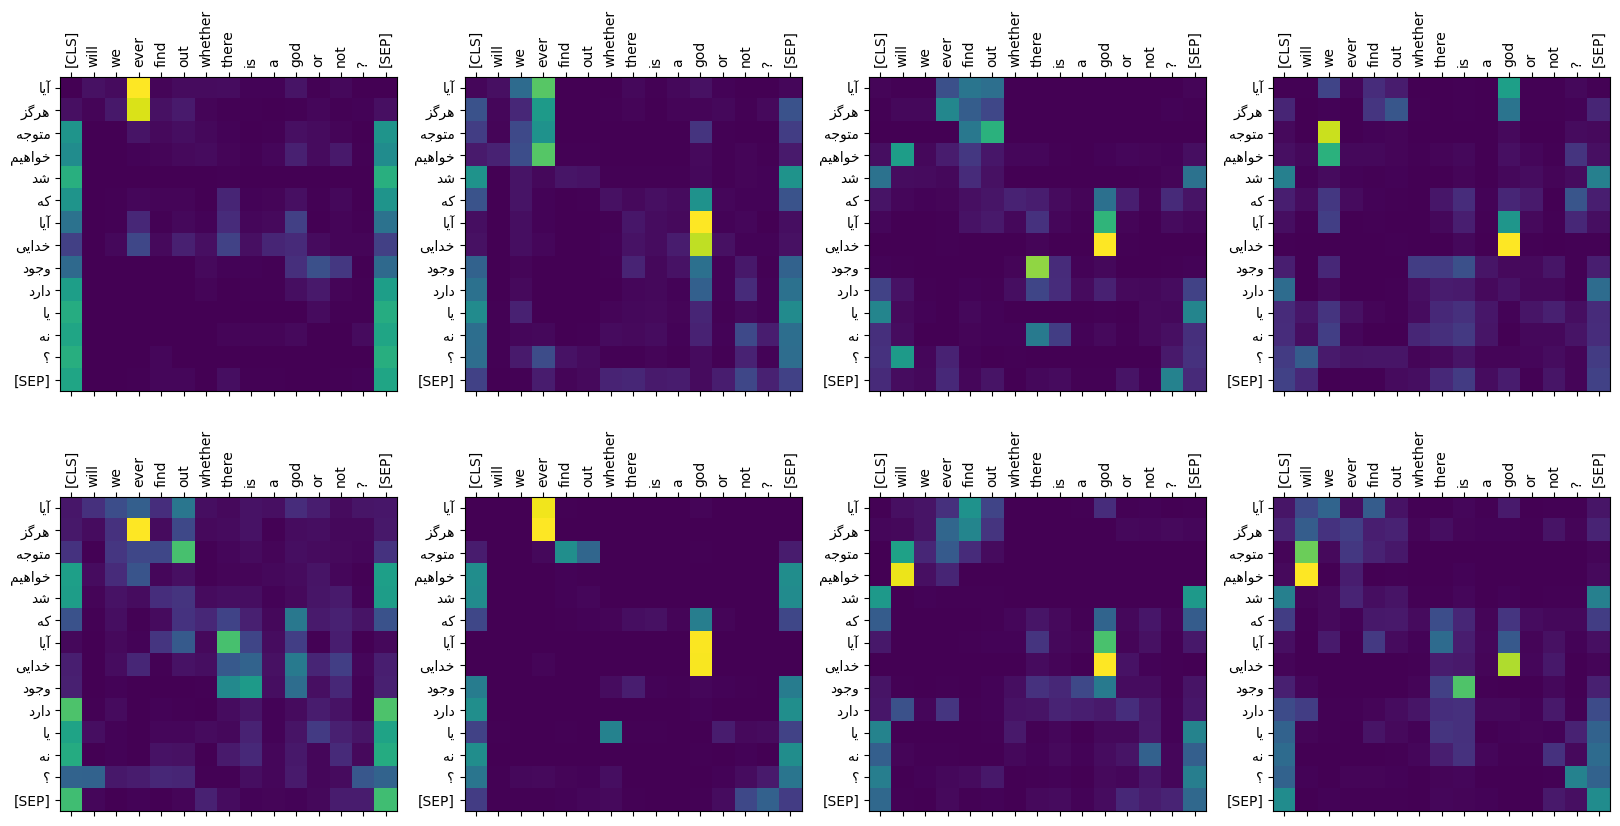

In [36]:
from bidi.algorithm import get_display
import arabic_reshaper

greedyTranslator = GreedyTranslator(transformer, fa_tokenizer, max_length=100, return_attention_weights=True)

sentence = 'will we ever find out whether there is a god or not?'
tokenized = en_tokenizer.encode(sentence, add_special_tokens=True)
tokenized = tf.expand_dims(tokenized, axis=0)
result, attention_scores = greedyTranslator(tokenized)
result = result.numpy()[0, 1:]

x_tick_labels = [en_tokenizer.decode([i]) for i in tokenized[0]]
y_tick_labels = [get_display(arabic_reshaper.reshape(fa_tokenizer.decode([i]))) for i in result]

fig = plt.figure(figsize=(20, 10))
for h in range(8):
    ax = plt.subplot(2, 4, h + 1)
    attentions = attention_scores[0][h]
    ax.matshow(attentions[:-1, :])
    ax.set_xticks(range(len(x_tick_labels)))
    ax.set_yticks(range(len(y_tick_labels)));
    ax.set_xticklabels(x_tick_labels, rotation=90);
    ax.set_yticklabels(y_tick_labels);

fig.savefig('./figures/attention_weights.png', dpi=320)

## Save the translator

In [21]:
transformer.save('./models/transformers_60M.tf')

INFO:tensorflow:Assets written to: ./models/transformers_60M.tf/assets


INFO:tensorflow:Assets written to: ./models/transformers_60M.tf/assets


In [23]:
tflite_converter = tf.lite.TFLiteConverter.from_saved_model('./models/transformers_60M.tf/')
tflite_converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,
    tf.lite.OpsSet.SELECT_TF_OPS
]
tflite_converter._experimental_lower_tensor_list_ops = False
tflite = tflite_converter.convert()

Summary on the non-converted ops:
---------------------------------
 * Accepted dialects: tfl, builtin, func
 * Non-Converted Ops: 296, Total Ops 1977, % non-converted = 14.97 %
 * 296 ARITH ops

- arith.constant:  296 occurrences  (f32: 264, i32: 32)



  (f32: 219)
  (f32: 36)
  (f32: 18)
  (i1: 28, i32: 25)
  (i1: 46)
  (f32: 60)
  (f32: 97)
  (f32: 2, i32: 50)
  (i1: 36)
  (f32: 60)
  (f32: 158)

  (i1: 2)
  (i32: 55)
  (i1: 28)
  (i32: 80)
  (f32: 236, i1: 25, i32: 30)
  (f32: 30)
  (i32: 55)
  (f32: 18)
  (f32: 30)
  (i1: 25, i32: 30)
  (f32: 48)
  (f32: 150)


In [24]:
with open('./models/transformers_60M.tflite', 'wb') as writer:
    writer.write(tflite)